In [13]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding
from keras.optimizers import Adam, SGD

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM

In [15]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [16]:
input_text = []
target_text = []

for line in open('D://Downloads//machine_learning_examples-master//machine_learning_examples-master//hmm_class//robert_frost.txt'):
    line = line.rstrip()
    if not line:
        continue
    
    input_line = '<sos> ' + line
    output_line = line + ' <eos>'
    
    input_text.append(input_line)
    target_text.append(output_line)

all_texts = input_text + target_text

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_texts)
input_sequences = tokenizer.texts_to_sequences(input_text)
target_sequences = tokenizer.texts_to_sequences(target_text)

max_len_from_data = max([len(s) for s in input_sequences])
print("Max sequence length ", max_len_from_data)

Max sequence length  12


In [17]:
word2idx = tokenizer.word_index
print('Found %s unique tokens' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens


In [18]:
max_sequence_length = min(max_len_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor', input_sequences.shape)

Shape of data tensor (1436, 12)


In [19]:
word2vec = {}
with open('D://Downloads//glove.6B//glove.6B.%sd.txt' % EMBEDDING_DIM, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
    print('Found %d word vectors' % len(word2vec))

Found 400000 word vectors


In [20]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print('Embedding Matrix shape: ', embedding_matrix.shape)

Embedding Matrix shape:  (3000, 50)


In [21]:
one_hot_targets = np.zeros((len(target_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
    for j, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, j, word] = 1

In [22]:
embedding_layer = Embedding(
                    num_words,
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                )

In [23]:
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c])
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.01),
    metrics=['accuracy']
)

In [24]:
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
    [input_sequences, z, z],
    one_hot_targets,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Train on 1148 samples, validate on 288 samples
Epoch 1/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 5.4237 - acc: 0.0093 - val_loss: 5.0951 - val_acc: 0.0058
Epoch 2/2000
1148/1148 [==============================] - 1s 937us/step - loss: 4.6635 - acc: 0.0334 - val_loss: 4.8294 - val_acc: 0.0833
Epoch 3/2000
1148/1148 [==============================] - 1s 960us/step - loss: 4.3868 - acc: 0.0833 - val_loss: 4.9277 - val_acc: 0.0833
Epoch 4/2000
1148/1148 [==============================] - 1s 945us/step - loss: 4.3348 - acc: 0.0833 - val_loss: 4.9391 - val_acc: 0.0833
Epoch 5/2000
1148/1148 [==============================] - 1s 933us/step - loss: 4.2942 - acc: 0.0833 - val_loss: 4.9815 - val_acc: 0.0833
Epoch 6/2000
1148/1148 [==============================] - 1s 930us/step - loss: 4.2669 - acc: 0.0833 - val_loss: 4.9663 - val_acc: 0.0833
Epoch 7/2000
1148/1148 [==============================] - 1s 933us/step - loss: 4.2198 - acc: 0.0833 - val_loss: 4.9043 - val_a

Epoch 60/2000
1148/1148 [==============================] - 1s 940us/step - loss: 2.5784 - acc: 0.2184 - val_loss: 5.1419 - val_acc: 0.0958
Epoch 61/2000
1148/1148 [==============================] - 1s 949us/step - loss: 2.5591 - acc: 0.2205 - val_loss: 5.1544 - val_acc: 0.0929
Epoch 62/2000
1148/1148 [==============================] - 1s 999us/step - loss: 2.5411 - acc: 0.2218 - val_loss: 5.1626 - val_acc: 0.0943
Epoch 63/2000
1148/1148 [==============================] - 1s 951us/step - loss: 2.5210 - acc: 0.2264 - val_loss: 5.1777 - val_acc: 0.0937
Epoch 64/2000
1148/1148 [==============================] - 1s 977us/step - loss: 2.5034 - acc: 0.2271 - val_loss: 5.1819 - val_acc: 0.0940
Epoch 65/2000
1148/1148 [==============================] - 1s 952us/step - loss: 2.4849 - acc: 0.2294 - val_loss: 5.1974 - val_acc: 0.0946
Epoch 66/2000
1148/1148 [==============================] - 1s 955us/step - loss: 2.4672 - acc: 0.2322 - val_loss: 5.2028 - val_acc: 0.0920
Epoch 67/2000
1148/1148 [==

Epoch 119/2000
1148/1148 [==============================] - 1s 942us/step - loss: 1.8470 - acc: 0.3188 - val_loss: 5.7062 - val_acc: 0.0836
Epoch 120/2000
1148/1148 [==============================] - 1s 996us/step - loss: 1.8403 - acc: 0.3206 - val_loss: 5.7089 - val_acc: 0.0830
Epoch 121/2000
1148/1148 [==============================] - 1s 978us/step - loss: 1.8334 - acc: 0.3232 - val_loss: 5.7183 - val_acc: 0.0825
Epoch 122/2000
1148/1148 [==============================] - 1s 974us/step - loss: 1.8257 - acc: 0.3226 - val_loss: 5.7224 - val_acc: 0.0833
Epoch 123/2000
1148/1148 [==============================] - 1s 952us/step - loss: 1.8190 - acc: 0.3256 - val_loss: 5.7236 - val_acc: 0.0845
Epoch 124/2000
1148/1148 [==============================] - 1s 946us/step - loss: 1.8135 - acc: 0.3240 - val_loss: 5.7435 - val_acc: 0.0810
Epoch 125/2000
1148/1148 [==============================] - 1s 950us/step - loss: 1.8070 - acc: 0.3276 - val_loss: 5.7528 - val_acc: 0.0802
Epoch 126/2000
1148/

1148/1148 [==============================] - 1s 950us/step - loss: 1.5070 - acc: 0.3764 - val_loss: 6.1291 - val_acc: 0.0784
Epoch 178/2000
1148/1148 [==============================] - 1s 947us/step - loss: 1.5037 - acc: 0.3799 - val_loss: 6.1264 - val_acc: 0.0787
Epoch 179/2000
1148/1148 [==============================] - 1s 939us/step - loss: 1.5010 - acc: 0.3793 - val_loss: 6.1437 - val_acc: 0.0778
Epoch 180/2000
1148/1148 [==============================] - 1s 943us/step - loss: 1.4959 - acc: 0.3804 - val_loss: 6.1342 - val_acc: 0.0784
Epoch 181/2000
1148/1148 [==============================] - 1s 949us/step - loss: 1.4916 - acc: 0.3820 - val_loss: 6.1505 - val_acc: 0.0778
Epoch 182/2000
1148/1148 [==============================] - 1s 950us/step - loss: 1.4871 - acc: 0.3824 - val_loss: 6.1544 - val_acc: 0.0770
Epoch 183/2000
1148/1148 [==============================] - 1s 956us/step - loss: 1.4821 - acc: 0.3805 - val_loss: 6.1637 - val_acc: 0.0775
Epoch 184/2000
1148/1148 [=========

1148/1148 [==============================] - 1s 965us/step - loss: 1.2918 - acc: 0.4218 - val_loss: 6.4531 - val_acc: 0.0741
Epoch 236/2000
1148/1148 [==============================] - 1s 950us/step - loss: 1.2889 - acc: 0.4226 - val_loss: 6.4481 - val_acc: 0.0758
Epoch 237/2000
1148/1148 [==============================] - 1s 942us/step - loss: 1.2845 - acc: 0.4233 - val_loss: 6.4455 - val_acc: 0.0761
Epoch 238/2000
1148/1148 [==============================] - 1s 944us/step - loss: 1.2833 - acc: 0.4248 - val_loss: 6.4634 - val_acc: 0.0747
Epoch 239/2000
1148/1148 [==============================] - 1s 941us/step - loss: 1.2822 - acc: 0.4233 - val_loss: 6.4712 - val_acc: 0.0752
Epoch 240/2000
1148/1148 [==============================] - 1s 949us/step - loss: 1.2786 - acc: 0.4243 - val_loss: 6.4809 - val_acc: 0.0738
Epoch 241/2000
1148/1148 [==============================] - 1s 934us/step - loss: 1.2764 - acc: 0.4262 - val_loss: 6.4854 - val_acc: 0.0752
Epoch 242/2000
1148/1148 [=========

1148/1148 [==============================] - 1s 963us/step - loss: 1.1476 - acc: 0.4521 - val_loss: 6.7584 - val_acc: 0.0709
Epoch 294/2000
1148/1148 [==============================] - 1s 958us/step - loss: 1.1458 - acc: 0.4527 - val_loss: 6.7607 - val_acc: 0.0694
Epoch 295/2000
1148/1148 [==============================] - 1s 972us/step - loss: 1.1430 - acc: 0.4538 - val_loss: 6.7467 - val_acc: 0.0735
Epoch 296/2000
1148/1148 [==============================] - 1s 969us/step - loss: 1.1395 - acc: 0.4548 - val_loss: 6.7640 - val_acc: 0.0703
Epoch 297/2000
1148/1148 [==============================] - 1s 958us/step - loss: 1.1370 - acc: 0.4548 - val_loss: 6.7548 - val_acc: 0.0712
Epoch 298/2000
1148/1148 [==============================] - 1s 970us/step - loss: 1.1339 - acc: 0.4575 - val_loss: 6.7677 - val_acc: 0.0709
Epoch 299/2000
1148/1148 [==============================] - 1s 957us/step - loss: 1.1316 - acc: 0.4571 - val_loss: 6.7704 - val_acc: 0.0706
Epoch 300/2000
1148/1148 [=========

Epoch 352/2000
1148/1148 [==============================] - 1s 950us/step - loss: 1.0345 - acc: 0.4779 - val_loss: 6.9558 - val_acc: 0.0666
Epoch 353/2000
1148/1148 [==============================] - 1s 972us/step - loss: 1.0333 - acc: 0.4772 - val_loss: 6.9466 - val_acc: 0.0680
Epoch 354/2000
1148/1148 [==============================] - 1s 958us/step - loss: 1.0314 - acc: 0.4768 - val_loss: 6.9586 - val_acc: 0.0663
Epoch 355/2000
1148/1148 [==============================] - 1s 946us/step - loss: 1.0285 - acc: 0.4779 - val_loss: 6.9686 - val_acc: 0.0660
Epoch 356/2000
1148/1148 [==============================] - 1s 945us/step - loss: 1.0272 - acc: 0.4782 - val_loss: 6.9833 - val_acc: 0.0660
Epoch 357/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 1.0253 - acc: 0.4792 - val_loss: 6.9751 - val_acc: 0.0674
Epoch 358/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 1.0248 - acc: 0.4792 - val_loss: 7.0012 - val_acc: 0.0651
Epoch 359/2000
1148/1148

Epoch 411/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.9569 - acc: 0.4941 - val_loss: 7.1868 - val_acc: 0.0651
Epoch 412/2000
1148/1148 [==============================] - 1s 999us/step - loss: 0.9558 - acc: 0.4943 - val_loss: 7.1795 - val_acc: 0.0663
Epoch 413/2000
1148/1148 [==============================] - 1s 987us/step - loss: 0.9548 - acc: 0.4944 - val_loss: 7.1910 - val_acc: 0.0651
Epoch 414/2000
1148/1148 [==============================] - 1s 963us/step - loss: 0.9520 - acc: 0.4966 - val_loss: 7.1900 - val_acc: 0.0668
Epoch 415/2000
1148/1148 [==============================] - 1s 995us/step - loss: 0.9521 - acc: 0.4953 - val_loss: 7.1886 - val_acc: 0.0634
Epoch 416/2000
1148/1148 [==============================] - 1s 953us/step - loss: 0.9519 - acc: 0.4947 - val_loss: 7.2040 - val_acc: 0.0642
Epoch 417/2000
1148/1148 [==============================] - 1s 972us/step - loss: 0.9491 - acc: 0.4944 - val_loss: 7.1972 - val_acc: 0.0668
Epoch 418/2000
1148/11

1148/1148 [==============================] - 1s 1ms/step - loss: 0.9099 - acc: 0.5038 - val_loss: 7.3351 - val_acc: 0.0660
Epoch 471/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.9072 - acc: 0.5065 - val_loss: 7.3450 - val_acc: 0.0651
Epoch 472/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.9044 - acc: 0.5047 - val_loss: 7.3663 - val_acc: 0.0645
Epoch 473/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.9002 - acc: 0.5068 - val_loss: 7.3397 - val_acc: 0.0660
Epoch 474/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.8979 - acc: 0.5083 - val_loss: 7.3623 - val_acc: 0.0637
Epoch 475/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.8989 - acc: 0.5071 - val_loss: 7.3474 - val_acc: 0.0631
Epoch 476/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.8987 - acc: 0.5070 - val_loss: 7.3544 - val_acc: 0.0637
Epoch 477/2000
1148/1148 [=======================

1148/1148 [==============================] - 1s 947us/step - loss: 0.8530 - acc: 0.5174 - val_loss: 7.5037 - val_acc: 0.0608
Epoch 530/2000
1148/1148 [==============================] - 1s 953us/step - loss: 0.8514 - acc: 0.5182 - val_loss: 7.5048 - val_acc: 0.0611
Epoch 531/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.8487 - acc: 0.5178 - val_loss: 7.4977 - val_acc: 0.0605
Epoch 532/2000
1148/1148 [==============================] - 1s 971us/step - loss: 0.8495 - acc: 0.5202 - val_loss: 7.4840 - val_acc: 0.0651
Epoch 533/2000
1148/1148 [==============================] - 1s 963us/step - loss: 0.8469 - acc: 0.5203 - val_loss: 7.5052 - val_acc: 0.0631
Epoch 534/2000
1148/1148 [==============================] - 1s 978us/step - loss: 0.8460 - acc: 0.5196 - val_loss: 7.5002 - val_acc: 0.0616
Epoch 535/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.8438 - acc: 0.5211 - val_loss: 7.5138 - val_acc: 0.0608
Epoch 536/2000
1148/1148 [=============

Epoch 588/2000
1148/1148 [==============================] - 1s 962us/step - loss: 0.8244 - acc: 0.5261 - val_loss: 7.6145 - val_acc: 0.0625
Epoch 589/2000
1148/1148 [==============================] - 1s 976us/step - loss: 0.8206 - acc: 0.5256 - val_loss: 7.6355 - val_acc: 0.0608
Epoch 590/2000
1148/1148 [==============================] - 1s 961us/step - loss: 0.8198 - acc: 0.5260 - val_loss: 7.6307 - val_acc: 0.0642
Epoch 591/2000
1148/1148 [==============================] - 1s 957us/step - loss: 0.8182 - acc: 0.5261 - val_loss: 7.6309 - val_acc: 0.0619
Epoch 592/2000
1148/1148 [==============================] - 1s 956us/step - loss: 0.8155 - acc: 0.5269 - val_loss: 7.6206 - val_acc: 0.0616
Epoch 593/2000
1148/1148 [==============================] - 1s 957us/step - loss: 0.8176 - acc: 0.5271 - val_loss: 7.6405 - val_acc: 0.0602
Epoch 594/2000
1148/1148 [==============================] - 1s 962us/step - loss: 0.8161 - acc: 0.5264 - val_loss: 7.6405 - val_acc: 0.0611
Epoch 595/2000
1148/

Epoch 647/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7933 - acc: 0.5303 - val_loss: 7.7162 - val_acc: 0.0651
Epoch 648/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7958 - acc: 0.5277 - val_loss: 7.7289 - val_acc: 0.0611
Epoch 649/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7925 - acc: 0.5319 - val_loss: 7.7281 - val_acc: 0.0619
Epoch 650/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7905 - acc: 0.5303 - val_loss: 7.7250 - val_acc: 0.0631
Epoch 651/2000
1148/1148 [==============================] - 1s 983us/step - loss: 0.7888 - acc: 0.5326 - val_loss: 7.7339 - val_acc: 0.0625
Epoch 652/2000
1148/1148 [==============================] - 1s 968us/step - loss: 0.7887 - acc: 0.5318 - val_loss: 7.7394 - val_acc: 0.0616
Epoch 653/2000
1148/1148 [==============================] - 1s 949us/step - loss: 0.7870 - acc: 0.5317 - val_loss: 7.7271 - val_acc: 0.0628
Epoch 654/2000
1148/1148 [==

Epoch 706/2000
1148/1148 [==============================] - 1s 956us/step - loss: 0.7714 - acc: 0.5359 - val_loss: 7.8338 - val_acc: 0.0582
Epoch 707/2000
1148/1148 [==============================] - 1s 952us/step - loss: 0.7706 - acc: 0.5350 - val_loss: 7.8221 - val_acc: 0.0584
Epoch 708/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7691 - acc: 0.5350 - val_loss: 7.8390 - val_acc: 0.0593
Epoch 709/2000
1148/1148 [==============================] - 1s 969us/step - loss: 0.7678 - acc: 0.5354 - val_loss: 7.7991 - val_acc: 0.0596
Epoch 710/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7692 - acc: 0.5356 - val_loss: 7.8268 - val_acc: 0.0582
Epoch 711/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7667 - acc: 0.5345 - val_loss: 7.8113 - val_acc: 0.0584
Epoch 712/2000
1148/1148 [==============================] - 1s 963us/step - loss: 0.7651 - acc: 0.5357 - val_loss: 7.8396 - val_acc: 0.0576
Epoch 713/2000
1148/1148 [

Epoch 765/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7614 - acc: 0.5338 - val_loss: 7.9415 - val_acc: 0.0550
Epoch 766/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7599 - acc: 0.5357 - val_loss: 7.9278 - val_acc: 0.0544
Epoch 767/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7613 - acc: 0.5348 - val_loss: 7.9341 - val_acc: 0.0553
Epoch 768/2000
1148/1148 [==============================] - 1s 969us/step - loss: 0.7620 - acc: 0.5339 - val_loss: 7.9313 - val_acc: 0.0558
Epoch 769/2000
1148/1148 [==============================] - 1s 946us/step - loss: 0.7595 - acc: 0.5331 - val_loss: 7.9549 - val_acc: 0.0544
Epoch 770/2000
1148/1148 [==============================] - 1s 945us/step - loss: 0.7581 - acc: 0.5361 - val_loss: 7.9615 - val_acc: 0.0553
Epoch 771/2000
1148/1148 [==============================] - 1s 973us/step - loss: 0.7578 - acc: 0.5349 - val_loss: 7.9603 - val_acc: 0.0561
Epoch 772/2000
1148/1148 [

Epoch 824/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7316 - acc: 0.5418 - val_loss: 8.0301 - val_acc: 0.0550
Epoch 825/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7350 - acc: 0.5401 - val_loss: 8.0309 - val_acc: 0.0538
Epoch 826/2000
1148/1148 [==============================] - 1s 989us/step - loss: 0.7345 - acc: 0.5402 - val_loss: 8.0402 - val_acc: 0.0532
Epoch 827/2000
1148/1148 [==============================] - 1s 973us/step - loss: 0.7345 - acc: 0.5413 - val_loss: 8.0406 - val_acc: 0.0530
Epoch 828/2000
1148/1148 [==============================] - 1s 969us/step - loss: 0.7350 - acc: 0.5396 - val_loss: 8.0218 - val_acc: 0.0550
Epoch 829/2000
1148/1148 [==============================] - 1s 945us/step - loss: 0.7376 - acc: 0.5396 - val_loss: 8.0228 - val_acc: 0.0541
Epoch 830/2000
1148/1148 [==============================] - 1s 935us/step - loss: 0.7399 - acc: 0.5389 - val_loss: 8.0283 - val_acc: 0.0535
Epoch 831/2000
1148/1148

Epoch 883/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.7214 - acc: 0.5437 - val_loss: 8.0945 - val_acc: 0.0506
Epoch 884/2000
1148/1148 [==============================] - 1s 988us/step - loss: 0.7215 - acc: 0.5420 - val_loss: 8.1105 - val_acc: 0.0524
Epoch 885/2000
1148/1148 [==============================] - 1s 971us/step - loss: 0.7177 - acc: 0.5456 - val_loss: 8.1121 - val_acc: 0.0521
Epoch 886/2000
1148/1148 [==============================] - 1s 984us/step - loss: 0.7163 - acc: 0.5452 - val_loss: 8.0877 - val_acc: 0.0541
Epoch 887/2000
1148/1148 [==============================] - 1s 977us/step - loss: 0.7147 - acc: 0.5453 - val_loss: 8.1110 - val_acc: 0.0518
Epoch 888/2000
1148/1148 [==============================] - 1s 976us/step - loss: 0.7153 - acc: 0.5447 - val_loss: 8.0921 - val_acc: 0.0535
Epoch 889/2000
1148/1148 [==============================] - 1s 986us/step - loss: 0.7139 - acc: 0.5454 - val_loss: 8.1016 - val_acc: 0.0506
Epoch 890/2000
1148/11

Epoch 942/2000
1148/1148 [==============================] - 1s 967us/step - loss: 0.7061 - acc: 0.5475 - val_loss: 8.1643 - val_acc: 0.0556
Epoch 943/2000
1148/1148 [==============================] - 1s 952us/step - loss: 0.7062 - acc: 0.5459 - val_loss: 8.1576 - val_acc: 0.0544
Epoch 944/2000
1148/1148 [==============================] - 1s 968us/step - loss: 0.7067 - acc: 0.5468 - val_loss: 8.1805 - val_acc: 0.0518
Epoch 945/2000
1148/1148 [==============================] - 1s 957us/step - loss: 0.7070 - acc: 0.5470 - val_loss: 8.1661 - val_acc: 0.0530
Epoch 946/2000
1148/1148 [==============================] - 1s 958us/step - loss: 0.7098 - acc: 0.5457 - val_loss: 8.1875 - val_acc: 0.0515
Epoch 947/2000
1148/1148 [==============================] - 1s 958us/step - loss: 0.7081 - acc: 0.5468 - val_loss: 8.1743 - val_acc: 0.0532
Epoch 948/2000
1148/1148 [==============================] - 1s 958us/step - loss: 0.7068 - acc: 0.5465 - val_loss: 8.1744 - val_acc: 0.0521
Epoch 949/2000
1148/

1148/1148 [==============================] - 1s 954us/step - loss: 0.7065 - acc: 0.5462 - val_loss: 8.2424 - val_acc: 0.0492
Epoch 1001/2000
1148/1148 [==============================] - 1s 964us/step - loss: 0.7035 - acc: 0.5466 - val_loss: 8.2332 - val_acc: 0.0518
Epoch 1002/2000
1148/1148 [==============================] - 1s 949us/step - loss: 0.7015 - acc: 0.5471 - val_loss: 8.2475 - val_acc: 0.0486
Epoch 1003/2000
1148/1148 [==============================] - 1s 938us/step - loss: 0.7020 - acc: 0.5475 - val_loss: 8.2267 - val_acc: 0.0492
Epoch 1004/2000
1148/1148 [==============================] - 1s 955us/step - loss: 0.6999 - acc: 0.5481 - val_loss: 8.2438 - val_acc: 0.0498
Epoch 1005/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6982 - acc: 0.5479 - val_loss: 8.2461 - val_acc: 0.0492
Epoch 1006/2000
1148/1148 [==============================] - 1s 943us/step - loss: 0.6966 - acc: 0.5485 - val_loss: 8.2544 - val_acc: 0.0492
Epoch 1007/2000
1148/1148 [====

1148/1148 [==============================] - 1s 943us/step - loss: 0.7021 - acc: 0.5455 - val_loss: 8.3159 - val_acc: 0.0495
Epoch 1059/2000
1148/1148 [==============================] - 1s 973us/step - loss: 0.6995 - acc: 0.5465 - val_loss: 8.2772 - val_acc: 0.0501
Epoch 1060/2000
1148/1148 [==============================] - 1s 960us/step - loss: 0.6995 - acc: 0.5467 - val_loss: 8.2995 - val_acc: 0.0469
Epoch 1061/2000
1148/1148 [==============================] - 1s 958us/step - loss: 0.7009 - acc: 0.5460 - val_loss: 8.2986 - val_acc: 0.0506
Epoch 1062/2000
1148/1148 [==============================] - 1s 958us/step - loss: 0.6975 - acc: 0.5467 - val_loss: 8.3184 - val_acc: 0.0483
Epoch 1063/2000
1148/1148 [==============================] - 1s 963us/step - loss: 0.6958 - acc: 0.5473 - val_loss: 8.3004 - val_acc: 0.0492
Epoch 1064/2000
1148/1148 [==============================] - 1s 964us/step - loss: 0.6934 - acc: 0.5480 - val_loss: 8.2836 - val_acc: 0.0498
Epoch 1065/2000
1148/1148 [==

1148/1148 [==============================] - 1s 935us/step - loss: 0.7117 - acc: 0.5414 - val_loss: 8.3623 - val_acc: 0.0506
Epoch 1117/2000
1148/1148 [==============================] - 1s 936us/step - loss: 0.7048 - acc: 0.5426 - val_loss: 8.3709 - val_acc: 0.0492
Epoch 1118/2000
1148/1148 [==============================] - 1s 932us/step - loss: 0.7000 - acc: 0.5449 - val_loss: 8.3621 - val_acc: 0.0472
Epoch 1119/2000
1148/1148 [==============================] - 1s 965us/step - loss: 0.6973 - acc: 0.5436 - val_loss: 8.3591 - val_acc: 0.0457
Epoch 1120/2000
1148/1148 [==============================] - 1s 936us/step - loss: 0.6947 - acc: 0.5476 - val_loss: 8.3626 - val_acc: 0.0457
Epoch 1121/2000
1148/1148 [==============================] - 1s 967us/step - loss: 0.6899 - acc: 0.5489 - val_loss: 8.3493 - val_acc: 0.0463
Epoch 1122/2000
1148/1148 [==============================] - 1s 961us/step - loss: 0.6910 - acc: 0.5482 - val_loss: 8.3589 - val_acc: 0.0472
Epoch 1123/2000
1148/1148 [==

1148/1148 [==============================] - 1s 959us/step - loss: 0.6993 - acc: 0.5445 - val_loss: 8.3979 - val_acc: 0.0477
Epoch 1175/2000
1148/1148 [==============================] - 1s 940us/step - loss: 0.6964 - acc: 0.5438 - val_loss: 8.3853 - val_acc: 0.0466
Epoch 1176/2000
1148/1148 [==============================] - 1s 943us/step - loss: 0.6912 - acc: 0.5473 - val_loss: 8.4022 - val_acc: 0.0477
Epoch 1177/2000
1148/1148 [==============================] - 1s 952us/step - loss: 0.6865 - acc: 0.5487 - val_loss: 8.3991 - val_acc: 0.0466
Epoch 1178/2000
1148/1148 [==============================] - 1s 935us/step - loss: 0.6866 - acc: 0.5476 - val_loss: 8.3845 - val_acc: 0.0475
Epoch 1179/2000
1148/1148 [==============================] - 1s 954us/step - loss: 0.6828 - acc: 0.5489 - val_loss: 8.3867 - val_acc: 0.0483
Epoch 1180/2000
1148/1148 [==============================] - 1s 946us/step - loss: 0.6814 - acc: 0.5491 - val_loss: 8.3787 - val_acc: 0.0475
Epoch 1181/2000
1148/1148 [==

1148/1148 [==============================] - 1s 1ms/step - loss: 0.6818 - acc: 0.5481 - val_loss: 8.4326 - val_acc: 0.0475
Epoch 1233/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6793 - acc: 0.5479 - val_loss: 8.3932 - val_acc: 0.0503
Epoch 1234/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6818 - acc: 0.5498 - val_loss: 8.4363 - val_acc: 0.0451
Epoch 1235/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6779 - acc: 0.5497 - val_loss: 8.4069 - val_acc: 0.0495
Epoch 1236/2000
1148/1148 [==============================] - 1s 984us/step - loss: 0.6745 - acc: 0.5510 - val_loss: 8.4452 - val_acc: 0.0469
Epoch 1237/2000
1148/1148 [==============================] - 1s 939us/step - loss: 0.6750 - acc: 0.5510 - val_loss: 8.4256 - val_acc: 0.0477
Epoch 1238/2000
1148/1148 [==============================] - 1s 956us/step - loss: 0.6757 - acc: 0.5502 - val_loss: 8.4306 - val_acc: 0.0469
Epoch 1239/2000
1148/1148 [==========

1148/1148 [==============================] - 1s 1ms/step - loss: 0.6916 - acc: 0.5483 - val_loss: 8.4446 - val_acc: 0.0506
Epoch 1291/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6890 - acc: 0.5508 - val_loss: 8.4300 - val_acc: 0.0515
Epoch 1292/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6882 - acc: 0.5500 - val_loss: 8.4402 - val_acc: 0.0512
Epoch 1293/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6899 - acc: 0.5497 - val_loss: 8.4352 - val_acc: 0.0501
Epoch 1294/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6876 - acc: 0.5494 - val_loss: 8.4391 - val_acc: 0.0506
Epoch 1295/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6852 - acc: 0.5503 - val_loss: 8.4429 - val_acc: 0.0501
Epoch 1296/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6841 - acc: 0.5500 - val_loss: 8.4491 - val_acc: 0.0503
Epoch 1297/2000
1148/1148 [================

Epoch 1349/2000
1148/1148 [==============================] - 1s 992us/step - loss: 0.6629 - acc: 0.5538 - val_loss: 8.4889 - val_acc: 0.0506
Epoch 1350/2000
1148/1148 [==============================] - 1s 996us/step - loss: 0.6648 - acc: 0.5535 - val_loss: 8.5023 - val_acc: 0.0498
Epoch 1351/2000
1148/1148 [==============================] - 1s 974us/step - loss: 0.6648 - acc: 0.5526 - val_loss: 8.5007 - val_acc: 0.0501
Epoch 1352/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6651 - acc: 0.5536 - val_loss: 8.5026 - val_acc: 0.0501
Epoch 1353/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6654 - acc: 0.5526 - val_loss: 8.5072 - val_acc: 0.0503
Epoch 1354/2000
1148/1148 [==============================] - 1s 990us/step - loss: 0.6662 - acc: 0.5532 - val_loss: 8.4955 - val_acc: 0.0486
Epoch 1355/2000
1148/1148 [==============================] - 1s 998us/step - loss: 0.6719 - acc: 0.5512 - val_loss: 8.5190 - val_acc: 0.0475
Epoch 1356/2000
1

1148/1148 [==============================] - 1s 1ms/step - loss: 0.6526 - acc: 0.5550 - val_loss: 8.5517 - val_acc: 0.0466
Epoch 1408/2000
1148/1148 [==============================] - 1s 994us/step - loss: 0.6522 - acc: 0.5538 - val_loss: 8.5549 - val_acc: 0.0463
Epoch 1409/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6527 - acc: 0.5548 - val_loss: 8.5622 - val_acc: 0.0477
Epoch 1410/2000
1148/1148 [==============================] - 1s 990us/step - loss: 0.6576 - acc: 0.5521 - val_loss: 8.5670 - val_acc: 0.0460
Epoch 1411/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6581 - acc: 0.5528 - val_loss: 8.5598 - val_acc: 0.0483
Epoch 1412/2000
1148/1148 [==============================] - 1s 991us/step - loss: 0.6588 - acc: 0.5525 - val_loss: 8.5533 - val_acc: 0.0486
Epoch 1413/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6569 - acc: 0.5537 - val_loss: 8.5783 - val_acc: 0.0483
Epoch 1414/2000
1148/1148 [==========

1148/1148 [==============================] - 1s 988us/step - loss: 0.6686 - acc: 0.5491 - val_loss: 8.5501 - val_acc: 0.0515
Epoch 1466/2000
1148/1148 [==============================] - 1s 981us/step - loss: 0.6733 - acc: 0.5475 - val_loss: 8.5599 - val_acc: 0.0486
Epoch 1467/2000
1148/1148 [==============================] - 1s 991us/step - loss: 0.6715 - acc: 0.5513 - val_loss: 8.5420 - val_acc: 0.0509
Epoch 1468/2000
1148/1148 [==============================] - 1s 980us/step - loss: 0.6686 - acc: 0.5499 - val_loss: 8.5578 - val_acc: 0.0489
Epoch 1469/2000
1148/1148 [==============================] - 1s 987us/step - loss: 0.6691 - acc: 0.5507 - val_loss: 8.5237 - val_acc: 0.0532
Epoch 1470/2000
1148/1148 [==============================] - 1s 990us/step - loss: 0.6686 - acc: 0.5496 - val_loss: 8.5300 - val_acc: 0.0518
Epoch 1471/2000
1148/1148 [==============================] - 1s 986us/step - loss: 0.6670 - acc: 0.5491 - val_loss: 8.5313 - val_acc: 0.0492
Epoch 1472/2000
1148/1148 [==

1148/1148 [==============================] - 1s 989us/step - loss: 0.6883 - acc: 0.5465 - val_loss: 8.5601 - val_acc: 0.0495
Epoch 1524/2000
1148/1148 [==============================] - 1s 993us/step - loss: 0.6793 - acc: 0.5477 - val_loss: 8.5528 - val_acc: 0.0501
Epoch 1525/2000
1148/1148 [==============================] - 1s 997us/step - loss: 0.6748 - acc: 0.5497 - val_loss: 8.5554 - val_acc: 0.0503
Epoch 1526/2000
1148/1148 [==============================] - 1s 993us/step - loss: 0.6750 - acc: 0.5489 - val_loss: 8.5698 - val_acc: 0.0472
Epoch 1527/2000
1148/1148 [==============================] - 1s 987us/step - loss: 0.6694 - acc: 0.5516 - val_loss: 8.5667 - val_acc: 0.0506
Epoch 1528/2000
1148/1148 [==============================] - 1s 992us/step - loss: 0.6650 - acc: 0.5523 - val_loss: 8.5746 - val_acc: 0.0489
Epoch 1529/2000
1148/1148 [==============================] - 1s 998us/step - loss: 0.6632 - acc: 0.5519 - val_loss: 8.5706 - val_acc: 0.0489
Epoch 1530/2000
1148/1148 [==

1148/1148 [==============================] - 1s 1ms/step - loss: 0.6474 - acc: 0.5541 - val_loss: 8.6160 - val_acc: 0.0489
Epoch 1582/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6493 - acc: 0.5531 - val_loss: 8.6049 - val_acc: 0.0489
Epoch 1583/2000
1148/1148 [==============================] - 1s 981us/step - loss: 0.6550 - acc: 0.5536 - val_loss: 8.6208 - val_acc: 0.0486
Epoch 1584/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6528 - acc: 0.5526 - val_loss: 8.6199 - val_acc: 0.0472
Epoch 1585/2000
1148/1148 [==============================] - 1s 990us/step - loss: 0.6515 - acc: 0.5536 - val_loss: 8.6149 - val_acc: 0.0495
Epoch 1586/2000
1148/1148 [==============================] - 1s 986us/step - loss: 0.6516 - acc: 0.5547 - val_loss: 8.6192 - val_acc: 0.0472
Epoch 1587/2000
1148/1148 [==============================] - 1s 978us/step - loss: 0.6538 - acc: 0.5511 - val_loss: 8.6384 - val_acc: 0.0472
Epoch 1588/2000
1148/1148 [========

1148/1148 [==============================] - 1s 989us/step - loss: 0.6464 - acc: 0.5557 - val_loss: 8.6110 - val_acc: 0.0483
Epoch 1640/2000
1148/1148 [==============================] - 1s 1ms/step - loss: 0.6450 - acc: 0.5552 - val_loss: 8.6098 - val_acc: 0.0486
Epoch 1641/2000
1148/1148 [==============================] - 1s 996us/step - loss: 0.6447 - acc: 0.5551 - val_loss: 8.6176 - val_acc: 0.0477
Epoch 1642/2000
1148/1148 [==============================] - 1s 969us/step - loss: 0.6450 - acc: 0.5552 - val_loss: 8.6084 - val_acc: 0.0489
Epoch 1643/2000
1148/1148 [==============================] - 1s 982us/step - loss: 0.6456 - acc: 0.5539 - val_loss: 8.6164 - val_acc: 0.0477
Epoch 1644/2000
1148/1148 [==============================] - 1s 996us/step - loss: 0.6450 - acc: 0.5555 - val_loss: 8.6157 - val_acc: 0.0495
Epoch 1645/2000
1148/1148 [==============================] - 1s 996us/step - loss: 0.6455 - acc: 0.5561 - val_loss: 8.6211 - val_acc: 0.0475
Epoch 1646/2000
1148/1148 [====

1148/1148 [==============================] - 1s 978us/step - loss: 0.6473 - acc: 0.5539 - val_loss: 8.6599 - val_acc: 0.0477
Epoch 1698/2000
1148/1148 [==============================] - 1s 985us/step - loss: 0.6502 - acc: 0.5538 - val_loss: 8.6582 - val_acc: 0.0477
Epoch 1699/2000
1148/1148 [==============================] - 1s 980us/step - loss: 0.6517 - acc: 0.5536 - val_loss: 8.6578 - val_acc: 0.0495
Epoch 1700/2000
1148/1148 [==============================] - 1s 979us/step - loss: 0.6516 - acc: 0.5538 - val_loss: 8.6529 - val_acc: 0.0506
Epoch 1701/2000
1148/1148 [==============================] - 1s 965us/step - loss: 0.6551 - acc: 0.5507 - val_loss: 8.6670 - val_acc: 0.0489
Epoch 1702/2000
1148/1148 [==============================] - 1s 974us/step - loss: 0.6595 - acc: 0.5510 - val_loss: 8.6608 - val_acc: 0.0486
Epoch 1703/2000
1148/1148 [==============================] - 1s 973us/step - loss: 0.6677 - acc: 0.5489 - val_loss: 8.6448 - val_acc: 0.0501
Epoch 1704/2000
1148/1148 [==

1148/1148 [==============================] - 1s 974us/step - loss: 0.6516 - acc: 0.5538 - val_loss: 8.6524 - val_acc: 0.0527
Epoch 1756/2000
1148/1148 [==============================] - 1s 970us/step - loss: 0.6514 - acc: 0.5526 - val_loss: 8.6792 - val_acc: 0.0486
Epoch 1757/2000
1148/1148 [==============================] - 1s 976us/step - loss: 0.6517 - acc: 0.5531 - val_loss: 8.6566 - val_acc: 0.0515
Epoch 1758/2000
1148/1148 [==============================] - 1s 983us/step - loss: 0.6489 - acc: 0.5552 - val_loss: 8.6686 - val_acc: 0.0486
Epoch 1759/2000
1148/1148 [==============================] - 1s 988us/step - loss: 0.6477 - acc: 0.5532 - val_loss: 8.6457 - val_acc: 0.0538
Epoch 1760/2000
1148/1148 [==============================] - 1s 976us/step - loss: 0.6521 - acc: 0.5535 - val_loss: 8.6854 - val_acc: 0.0492
Epoch 1761/2000
1148/1148 [==============================] - 1s 981us/step - loss: 0.6526 - acc: 0.5531 - val_loss: 8.6379 - val_acc: 0.0530
Epoch 1762/2000
1148/1148 [==

1148/1148 [==============================] - 1s 980us/step - loss: 0.6522 - acc: 0.5530 - val_loss: 8.6570 - val_acc: 0.0489
Epoch 1814/2000
1148/1148 [==============================] - 1s 981us/step - loss: 0.6520 - acc: 0.5523 - val_loss: 8.6640 - val_acc: 0.0486
Epoch 1815/2000
1148/1148 [==============================] - 1s 996us/step - loss: 0.6488 - acc: 0.5539 - val_loss: 8.6663 - val_acc: 0.0489
Epoch 1816/2000
1148/1148 [==============================] - 1s 987us/step - loss: 0.6477 - acc: 0.5536 - val_loss: 8.6780 - val_acc: 0.0466
Epoch 1817/2000
1148/1148 [==============================] - 1s 993us/step - loss: 0.6478 - acc: 0.5546 - val_loss: 8.6664 - val_acc: 0.0483
Epoch 1818/2000
1148/1148 [==============================] - 1s 991us/step - loss: 0.6457 - acc: 0.5536 - val_loss: 8.6682 - val_acc: 0.0460
Epoch 1819/2000
1148/1148 [==============================] - 1s 971us/step - loss: 0.6446 - acc: 0.5553 - val_loss: 8.6562 - val_acc: 0.0483
Epoch 1820/2000
1148/1148 [==

1148/1148 [==============================] - 1s 970us/step - loss: 0.6754 - acc: 0.5452 - val_loss: 8.6827 - val_acc: 0.0495
Epoch 1872/2000
1148/1148 [==============================] - 1s 959us/step - loss: 0.6878 - acc: 0.5433 - val_loss: 8.6844 - val_acc: 0.0454
Epoch 1873/2000
1148/1148 [==============================] - 1s 958us/step - loss: 0.6946 - acc: 0.5414 - val_loss: 8.6822 - val_acc: 0.0472
Epoch 1874/2000
1148/1148 [==============================] - 1s 960us/step - loss: 0.7008 - acc: 0.5407 - val_loss: 8.6654 - val_acc: 0.0480
Epoch 1875/2000
1148/1148 [==============================] - 1s 959us/step - loss: 0.6999 - acc: 0.5393 - val_loss: 8.6939 - val_acc: 0.0472
Epoch 1876/2000
1148/1148 [==============================] - 1s 963us/step - loss: 0.7058 - acc: 0.5399 - val_loss: 8.7161 - val_acc: 0.0472
Epoch 1877/2000
1148/1148 [==============================] - 1s 965us/step - loss: 0.7080 - acc: 0.5393 - val_loss: 8.7211 - val_acc: 0.0492
Epoch 1878/2000
1148/1148 [==

1148/1148 [==============================] - 1s 984us/step - loss: 0.6333 - acc: 0.5568 - val_loss: 8.7146 - val_acc: 0.0486
Epoch 1930/2000
1148/1148 [==============================] - 1s 975us/step - loss: 0.6340 - acc: 0.5557 - val_loss: 8.7132 - val_acc: 0.0489
Epoch 1931/2000
1148/1148 [==============================] - 1s 983us/step - loss: 0.6336 - acc: 0.5544 - val_loss: 8.7011 - val_acc: 0.0469
Epoch 1932/2000
1148/1148 [==============================] - 1s 983us/step - loss: 0.6335 - acc: 0.5569 - val_loss: 8.7108 - val_acc: 0.0475
Epoch 1933/2000
1148/1148 [==============================] - 1s 986us/step - loss: 0.6339 - acc: 0.5552 - val_loss: 8.7134 - val_acc: 0.0475
Epoch 1934/2000
1148/1148 [==============================] - 1s 987us/step - loss: 0.6340 - acc: 0.5564 - val_loss: 8.6961 - val_acc: 0.0503
Epoch 1935/2000
1148/1148 [==============================] - 1s 987us/step - loss: 0.6336 - acc: 0.5561 - val_loss: 8.6963 - val_acc: 0.0498
Epoch 1936/2000
1148/1148 [==

1148/1148 [==============================] - 1s 964us/step - loss: 0.6543 - acc: 0.5521 - val_loss: 8.6820 - val_acc: 0.0524
Epoch 1988/2000
1148/1148 [==============================] - 1s 957us/step - loss: 0.6558 - acc: 0.5535 - val_loss: 8.6903 - val_acc: 0.0489
Epoch 1989/2000
1148/1148 [==============================] - 1s 963us/step - loss: 0.6507 - acc: 0.5533 - val_loss: 8.6920 - val_acc: 0.0495
Epoch 1990/2000
1148/1148 [==============================] - 1s 954us/step - loss: 0.6468 - acc: 0.5539 - val_loss: 8.6653 - val_acc: 0.0506
Epoch 1991/2000
1148/1148 [==============================] - 1s 963us/step - loss: 0.6470 - acc: 0.5556 - val_loss: 8.6812 - val_acc: 0.0509
Epoch 1992/2000
1148/1148 [==============================] - 1s 966us/step - loss: 0.6473 - acc: 0.5539 - val_loss: 8.6942 - val_acc: 0.0501
Epoch 1993/2000
1148/1148 [==============================] - 1s 963us/step - loss: 0.6454 - acc: 0.5547 - val_loss: 8.6754 - val_acc: 0.0527
Epoch 1994/2000
1148/1148 [==

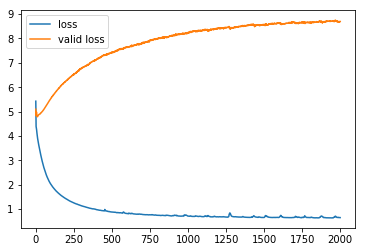

In [25]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='valid loss')
plt.legend()
plt.show()

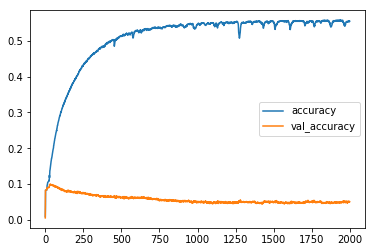

In [26]:
plt.plot(r.history['acc'], label='accuracy')
plt.plot(r.history['val_acc'], label='val_accuracy')
plt.legend()
plt.show()

In [27]:
input2 = Input((1,))
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c])
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [28]:
idx2word = {v:k for k, v in word2idx.items()}

In [29]:
def sample_line():
    np_input = np.array([[word2idx['<sos>']]])
    h = np.zeros((1, LATENT_DIM))
    c = np.zeros((1, LATENT_DIM))
    
    eos = word2idx['<eos>']
    
    output_sentence = []
    
    for _ in range(max_sequence_length):
        o, h, c = sampling_model.predict([np_input, h, c])

        probs = o[0,0]
        if np.argmax(probs) == 0:
            print('wtf')
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(probs), p=probs)
        if idx == eos:
            break
        
        output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))
        
        np_input[0,0] = idx
    
    return ' '.join(output_sentence)

In [30]:
while True:
    for _ in range(4):
        print(sample_line())
        
    ans = input('---generate another? [Y/n]---')
    if ans and ans[0].lower().startswith('n'):
        break

'toffile, get nails.' i give i'm just to perish twice,
comes softly rattling down.
the life is not yet all gone out of it.
the road there, if you'll let one, and hurt your name,
---generate another? [Y/n]---y
describing rings of lantern light.
i guess he found he got more out of me
still said to haunt this side of panther mountain.
they spoke of the sun
---generate another? [Y/n]---y
we were about it we for bricks,
'is this some trance you are withdrawing into?'
it's when it left at to one any more your waters and
and the smell of fire drowned in rain
---generate another? [Y/n]---y
now slowly closing like a dent in dough.
but welcomed for the sound of the stake or something.
he fell and made the lantern rattle
who failed to find or force no more a town.
---generate another? [Y/n]---y
i had such company outward bound.
he said you in winter off from the day.'
drink and be whole again beyond confusion.
or old love on an impulse not to care-
---generate another? [Y/n]---n
